In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading data

In [2]:
train_file = open("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/train.txt","r")
train = train_file.read()

In [3]:
train = train.split('\n')
train = train[:-1]
print("Examples in test dataset:", len(train))
x_train = [data_example.split(' ')[0] for data_example in train]
y_train = [data_example.split(' ')[1] for data_example in train]

Examples in test dataset: 83194


In [4]:
print("Examples in x_train = ", len(x_train))
print("Examples in y_train = ", len(y_train))
print(x_train[:5])
print
print(y_train[:5])

Examples in x_train =  83194
Examples in y_train =  83194
['LEMIEUX', 'MINDING', 'STRIPED', 'KEN', 'CONFERENCE']
['L_AH_M_Y_UW', 'M_AY_N_D_IH_NG', 'S_T_R_AY_P_T', 'K_EH_N', 'K_AA_N_F_ER_AH_N_S']


In [5]:
print("Longest word in x_train -", max(x_train, key=len), "with len =", len(max(x_train, key=len)))
print("Longest word in y_train -", max(y_train, key=len), "with len =", len(max(y_train, key=len)))

Longest word in x_train - SUPERCALIFRAGILISTICEXPIALIDOCIOUS with len = 34
Longest word in y_train - S_UW_P_ER_K_AE_L_AH_F_R_AE_JH_AH_L_IH_S_T_IH_K_EH_K_S_P_IY_AE_L_AH_D_OW_SH_AH_S with len = 79


### First model architecture:
Represent each char as one-hot, use seq2seq without attention

### Second model architecture:
Represent each char as embedding, use seq2seq without attention

### Third model architecture:
Represent each char as embedding, use seq2seq with attention

### EXTRA Improvements:
Train biderectional rnn

### Preprocessing

In [198]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 100

class Vocab:
    def __init__(self):
        self.char2idx = {'s': 0, 'e': 1}
        self.idx2char = {0: 's', 1: 'e'}
        self.n_words = 2
    
    def addWord(self, word):
        for char in word:
            self.addChar(char)
            
    def addChar(self, char):
        if char not in self.char2idx:
            self.char2idx[char] = self.n_words
            self.idx2char[self.n_words] = char
            self.n_words += 1
        
    def tokenize(self, sequence):
        return [self.char2idx[sym] for sym in sequence]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[num] for num in sequence])

In [199]:
def readLang(x_train, y_train, reverse=False):
    input_lang = Vocab()
    output_lang = Vocab()
    
    pairs = []
    for word in x_train:
        input_lang.addWord(word)
    for word in y_train:
        output_lang.addWord(word)
        
    for i in range(len(x_train)):
         pairs.append([x_train[i], y_train[i]])
                       
    return input_lang, output_lang, pairs

In [200]:
input_lang, output_lang, pairs = readLang(x_train, y_train)

In [201]:
print(pairs[:10])

[['LEMIEUX', 'L_AH_M_Y_UW'], ['MINDING', 'M_AY_N_D_IH_NG'], ['STRIPED', 'S_T_R_AY_P_T'], ['KEN', 'K_EH_N'], ['CONFERENCE', 'K_AA_N_F_ER_AH_N_S'], ['IMMOLATE', 'IH_M_AH_L_EY_T'], ['TRANSGRESS', 'T_R_AE_N_Z_G_R_EH_S'], ['RABBLE', 'R_AE_B_AH_L'], ['AIRSHARE', 'EH_R_SH_EH_R'], ['INTOLERANCE', 'IH_N_T_AA_L_ER_AH_N_S']]


In [202]:
print(random.choice(pairs))

['PATRIDGE', 'P_AE_T_R_IH_JH']


In [203]:
for key,value in input_lang.char2idx.items():
    print(key, " - ", value)

s  -  0
e  -  1
L  -  2
E  -  3
M  -  4
I  -  5
U  -  6
X  -  7
N  -  8
D  -  9
G  -  10
S  -  11
T  -  12
R  -  13
P  -  14
K  -  15
C  -  16
O  -  17
F  -  18
A  -  19
B  -  20
H  -  21
V  -  22
Y  -  23
W  -  24
J  -  25
'  -  26
Q  -  27
Z  -  28
-  -  29


In [204]:
for key,value in output_lang.char2idx.items():
    print(key, " - ", value)

s  -  0
e  -  1
L  -  2
_  -  3
A  -  4
H  -  5
M  -  6
Y  -  7
U  -  8
W  -  9
N  -  10
D  -  11
I  -  12
G  -  13
S  -  14
T  -  15
R  -  16
P  -  17
K  -  18
E  -  19
F  -  20
Z  -  21
B  -  22
V  -  23
O  -  24
J  -  25
C  -  26


In [162]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [163]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [164]:
    class AttnDecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
            super(AttnDecoderRNN, self).__init__()
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.dropout_p = dropout_p
            self.max_length = max_length

            self.embedding = nn.Embedding(self.output_size, self.hidden_size)
            self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
            self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.dropout = nn.Dropout(self.dropout_p)
            self.gru = nn.GRU(self.hidden_size, self.hidden_size)
            self.out = nn.Linear(self.hidden_size, self.output_size)

        def forward(self, input, hidden, encoder_outputs):
            embedded = self.embedding(input).view(1, 1, -1)
            embedded = self.dropout(embedded)

            attn_weights = F.softmax(
                self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                     encoder_outputs.unsqueeze(0))

            output = torch.cat((embedded[0], attn_applied[0]), 1)
            output = self.attn_combine(output).unsqueeze(0)

            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, hidden, attn_weights

        def initHidden(self):
            return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

In [165]:
def indexesFromWord(vocab, word):
    return [vocab.char2idx[char] for char in word]

def tensorFromWord(vocab, word):
    indexes = indexesFromWord(vocab, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [240]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [241]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [242]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [243]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [244]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

In [245]:
def predict(encoder, decoder, x):
    y = []
    for i in range(len(x)):
        if i % 1000 == 0:
            print("Progress:", i, "/", len(x))
        output_words, _ = evaluate(encoder, decoder, x[i])
        output_sentence = ''.join(output_words)
        output_sentence = output_sentence
        y.append(output_sentence)
    print("Finished!!! ")
    return y

In [246]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

2m 6s (- 208m 43s) (1000 1%) 2.0674
4m 5s (- 200m 15s) (2000 2%) 1.9046
6m 5s (- 196m 48s) (3000 3%) 1.8758
8m 5s (- 194m 11s) (4000 4%) 1.9015
10m 4s (- 191m 34s) (5000 5%) 1.6106
12m 3s (- 188m 47s) (6000 6%) 1.3537
14m 1s (- 186m 16s) (7000 7%) 1.2378
16m 0s (- 184m 3s) (8000 8%) 1.1200
17m 56s (- 181m 28s) (9000 9%) 1.0387
19m 56s (- 179m 25s) (10000 10%) 1.0385
21m 57s (- 177m 37s) (11000 11%) 1.0017
23m 57s (- 175m 40s) (12000 12%) 0.9784
25m 57s (- 173m 43s) (13000 13%) 0.9217
27m 57s (- 171m 44s) (14000 14%) 0.9129
29m 56s (- 169m 39s) (15000 15%) 0.8540
31m 55s (- 167m 34s) (16000 16%) 0.8322
33m 55s (- 165m 38s) (17000 17%) 0.8119
35m 54s (- 163m 34s) (18000 18%) 0.8124
37m 54s (- 161m 35s) (19000 19%) 0.7855
39m 54s (- 159m 36s) (20000 20%) 0.8090
41m 54s (- 157m 40s) (21000 21%) 0.7989
43m 53s (- 155m 36s) (22000 22%) 0.7391
45m 52s (- 153m 36s) (23000 23%) 0.7250
47m 52s (- 151m 36s) (24000 24%) 0.7563
49m 52s (- 149m 38s) (25000 25%) 0.7483
51m 50s (- 147m 34s) (26000 26%

<Figure size 432x288 with 0 Axes>

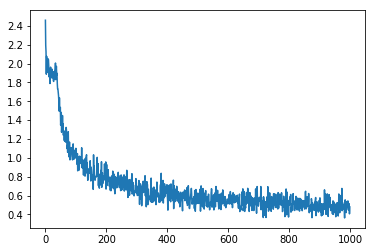

In [247]:
trainIters(encoder1, attn_decoder1, 100000, print_every=1000)

In [249]:
path = "/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/Models/"
torch.save(encoder1.state_dict(), path + "encoder_baseline_hd=512")
torch.save(attn_decoder1.state_dict(), path + "decoder_baseline_hd=512")

In [208]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder1.load_state_dict(torch.load(path + "encoder_baseline"))
encoder1.eval()

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1.load_state_dict(torch.load(path + "decoder_baseline"))
attn_decoder1.eval()

AttnDecoderRNN(
  (embedding): Embedding(27, 256)
  (attn): Linear(in_features=512, out_features=100, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=27, bias=True)
)

#### Postprocessing:
trim extra '_' symbols

In [252]:
predicted = predict(encoder1, attn_decoder1, x_train[:5000])

Progress: 0 / 5000
Progress: 1000 / 5000
Progress: 2000 / 5000
Progress: 3000 / 5000
Progress: 4000 / 5000
Finished!!! 


In [217]:
evaluateRandomly(encoder1, attn_decoder1)

> GEARED
= G_IH_R_D
< Z_EE__R_D

> TIJUANA
= T_IH_W_AA_N_AH
< T_IY_JH_AAAN_AH

> FURGERSON
= F_ER_G_ER_S_AH_N
< F_ER_G_EH_S_A___

> JALAPENO
= HH_AE_L_AH_P_IY_N_Y_OW
< Y_AA_L_AA_P_EH_N_OW

> RECORDING
= R_AH_K_AO_R_D_IH_NG
< R_IH_K_AO_R_D_IH_NG

> ROCKETS
= R_AA_K_AH_T_S
< R_AA_K_AH_T_S

> GRANSTROM
= G_R_AE_N_S_T_R_AH_M
< G_R_AE_N_S_T_R_AH_M_AH_M

> BUTTERS
= B_AH_T_ER_Z
< B_AH_T_ER_Z

> ANOMIE
= AE_N_AH_M_IY
< AA_N_AA_M_IY

> NUTLETS
= N_AH_T_L_AH_T_S
< N_AH_T_L_AH_T_S



In [61]:
import pandas as pd

In [182]:
test_data = pd.read_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/test.csv")
test_data.head()

,Id,Word
0,1,PITCHED
1,2,DISSOLVERS
2,3,SCRAWNY
3,4,BONENFANT
4,5,EXCEEDS


In [184]:
x_test = list(test_data['Word'])
print(len(x_test))
print(type(x_test))
print(x_test[:10])
print(x_test[-10:])

41597
<class 'list'>
['PITCHED', 'DISSOLVERS', 'SCRAWNY', 'BONENFANT', 'EXCEEDS', 'BARTNICKI', 'BUTE', 'CAPITULATE', 'STEAM', 'INVESTCORP']
['HUPFER', 'LEATHERMAN', 'LUPATKIN', 'ELABORATELY', 'ARRUPE', 'INOCULATION', 'UNTO', 'SCOGIN', 'HESSION', 'TARNOWSKI']


In [185]:
print(x_test[0])

PITCHED


In [186]:
y_test = []

In [187]:
y_test = predict(encoder1, attn_decoder1, x_test)

Progress: 0 / 41597
Progress: 1000 / 41597
Progress: 2000 / 41597
Progress: 3000 / 41597
Progress: 4000 / 41597
Progress: 5000 / 41597
Progress: 6000 / 41597
Progress: 7000 / 41597
Progress: 8000 / 41597
Progress: 9000 / 41597
Progress: 10000 / 41597
Progress: 11000 / 41597
Progress: 12000 / 41597
Progress: 13000 / 41597
Progress: 14000 / 41597
Progress: 15000 / 41597
Progress: 16000 / 41597
Progress: 17000 / 41597
Progress: 18000 / 41597
Progress: 19000 / 41597
Progress: 20000 / 41597
Progress: 21000 / 41597
Progress: 22000 / 41597
Progress: 23000 / 41597
Progress: 24000 / 41597
Progress: 25000 / 41597
Progress: 26000 / 41597
Progress: 27000 / 41597
Progress: 28000 / 41597
Progress: 29000 / 41597
Progress: 30000 / 41597
Progress: 31000 / 41597
Progress: 32000 / 41597
Progress: 33000 / 41597
Progress: 34000 / 41597
Progress: 35000 / 41597
Progress: 36000 / 41597
Progress: 37000 / 41597
Progress: 38000 / 41597
Progress: 39000 / 41597
Progress: 40000 / 41597
Progress: 41000 / 41597
Finis

In [193]:
for i in range(len(y_test)):
    y_test[i] = y_test[i][:-1]

In [194]:
print(y_test[:10])

['P_IH_CH_T', 'D_AY_S_AH_L_V_ER_Z', 'S_K_R_AO_N_IY', 'B_AH_N_IH_N_F_AE_N_T', 'EH_K_S_K_K_K_K_S_IH_Z', 'B_AA_R_T_N_N_IH_K_IY', 'B_UW_T', 'K_AE_P_IH_T_AH_L_EY_T', 'S_T_EH_M', 'IH_N_AH_S_T_AH_S_T_AH_P_T']


In [195]:
submission = pd.read_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/test.csv")
submission['Word'] = y_test

In [196]:
print(submission.head())

   Id                   Word
0   1              P_IH_CH_T
1   2     D_AY_S_AH_L_V_ER_Z
2   3          S_K_R_AO_N_IY
3   4   B_AH_N_IH_N_F_AE_N_T
4   5  EH_K_S_K_K_K_K_S_IH_Z


In [197]:
submission.to_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/submission_baseline_tf=0.5_no_.csv")

In [2]:
import pandas as pd

In [13]:
submission = pd.read_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/submission_baseline.csv")

In [14]:
submission.head()

,Id,Transcription
0,1,P_IH_CH_T
1,2,D_IH_Z_OW_L_EH_R_ER_Z
2,3,S_K_R_AE_N_IY
3,4,B_OA_N_EH_N_AH_N_T
4,5,IH_G_Z_EY_D_Z


In [20]:
y_test = list(submission['Transcription'])

In [21]:
y_test[16]

'AH_N_IH_N_AH_T_E_______R_L_IY'

In [23]:
for i in range(len(y_test)):
    y_test[i].strip('_')
    
for i in range(len(y_test)):
    j = 0
    new_str = ""
    while j < len(y_test[i]) - 1:
        if y_test[i][j:j+2] == '__':
            tmp = 1
        else:
            new_str += y_test[i][j]
        j += 1
    new_str += y_test[i][-1]
    
    y_test[i] = new_str

In [24]:
print(y_test[:10])

['P_IH_CH_T', 'D_IH_Z_OW_L_EH_R_ER_Z', 'S_K_R_AE_N_IY', 'B_OA_N_EH_N_AH_N_T', 'IH_G_Z_EY_D_Z', 'B_AA_R_T_AH_N_IH_K_IY', 'B_Y_UW_T', 'K_AA_P_IH_L_AY_L_EH', 'S_T_IY_M', 'IH_N_V_EH_S_K_T_AA_R_P_K_ER']


In [25]:
y_test[16]

'AH_N_IH_N_AH_T_E_R_L_IY'

In [26]:
submission['Transcription'] = y_test

In [28]:
submission.to_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/submission_baseline_1.csv")

#### This solution gives 30% accuracy for test data in this competition